In [30]:
import pandas as pd

def getUserId(id):
    val = ""
    if id < 10:
        val += "00"
        val += str(id)
    elif id < 100:
        val += "0"
        val += str(id)
    else:
        val = str(id)
    return val

min_lat_list = []
min_lon_list = []
max_lat_list = []
max_lon_list = []
min_x_list = []
min_y_list = []
max_x_list = []
max_y_list = []

user_id_list = []
for id in range(182):
    user_id = getUserId(id)
    csv_file = './Data/' + user_id + '/csv/' + user_id + '.csv'
    df = pd.read_csv(csv_file)
    if df.shape[0] < 500:
        continue

    user0 = df[['days', 'latitude', 'longitude']].copy()
    user_id_list += [user_id]
    min_lat_list += [user0['latitude'].min()]
    max_lat_list += [user0['latitude'].max()]
    min_lon_list += [user0['longitude'].min()]
    max_lon_list += [user0['longitude'].max()]
    min_x_list += [user0['x'].min()]
    min_y_list += [user0['y'].min()]
    max_x_list += [user0['x'].max()]
    max_y_list += [user0['y'].max()]

user_location_df = pd.DataFrame({'user_id':user_id_list,
                                'min_lat':min_lat_list,
                                'min_lon':min_lon_list,
                                'max_lat':max_lat_list,
                                'max_lon':max_lon_list,
                                'min_x':min_x_list,
                                'min_y':min_y_list,
                                'max_x':max_x_list,
                                'max_y':max_y_l})

FileNotFoundError: [Errno 2] No such file or directory: './Data/000/csv/000converted.csv'

In [27]:
user_location_df_pre = user_location_df.copy()
user_location_df_pre = user_location_df_pre.set_index('user_id', drop=True).copy()
user_location_df_pre.head(2)

X = ['min_lat', 'min_lon', 'max_lat', 'max_lon']
q1 = user_location_df_pre[X].quantile(0.25)
q3 = user_location_df_pre[X].quantile(0.75)
iqr = (q3-q1) * 1.5

cond1 = user_location_df_pre[X] >= (q1 - iqr)
user_location_df_pre = user_location_df_pre[cond1].dropna().copy()
print(user_location_df_pre.shape)

cond2 = user_location_df_pre[X] <= (q3 + iqr)
user_location_df_pre = user_location_df_pre[cond2].dropna().copy()
print(user_location_df_pre.shape)
user_location_df_pre.min()
user_location_df_pre.max()

(139, 4)
(126, 4)


min_lat     39.975300
min_lon    116.452488
max_lat     41.367085
max_lon    122.651456
dtype: float64

In [22]:
valid_user_list = user_location_df_pre.index
valid_user_list = pd.DataFrame({'valid_user_list':user_location_df_pre.index})


In [62]:
min_lat = 1000000 
min_lon = 1000000
max_lat = 0
max_lon = 0

X = ['latitude', 'longitude', 'x', 'y']
user_min_df = pd.DataFrame(columns=X)
user_max_df = pd.DataFrame(columns=X)
for user_id in valid_user_list['valid_user_list']:
    # user_id = getUserId(id)
    csv_file = './Data/' + user_id + '/csv/' + user_id + '_converted.csv'
    user0 = pd.read_csv(csv_file)
    min_df = pd.DataFrame(data=user0[X].min()).transpose()
    max_df = pd.DataFrame(data=user0[X].max()).transpose()
    
    user_min_df = pd.concat([user_min_df, min_df])
    user_max_df = pd.concat([user_max_df, max_df])

In [67]:
print(user_min_df[['x', 'y']].min())
print(user_max_df[['x', 'y']].max())

x   -5.519056e+05
y   -1.068556e+06
dtype: float64
x    4.665059e+05
y    1.068556e+06
dtype: float64


In [90]:
df_min = pd.DataFrame(user_min_df.min()).transpose()
df_max = pd.DataFrame(user_min_df.max()).transpose()
df_max_min = pd.DataFrame(user_min_df.max()-user_min_df.min()).transpose()
df_diff = pd.concat([df_min, df_max, df_max_min])
df_diff['label'] = ['min', 'max', 'max-min']

round(df_diff.set_index('label'), 3)

,latitude,longitude,x,y
label,,,,
min,22.148,111.565,-551905.607,-1068555.891
max,39.975,116.452,-55870.139,913796.460
max-min,17.828,4.888,496035.468,1982352.351


,latitude,longitude,x,y,days,time
96660,39.998507,116.306632,-68264.395763,916376.960785,39793.490868,11:46:51
96720,39.999183,116.308833,-68076.235987,916452.128555,39793.494225,11:51:41
96780,40.002152,116.308738,-68081.367817,916782.266293,39793.497685,11:56:40
96840,40.004957,116.312070,-67794.770776,917094.168062,39793.499977,11:59:58
96900,40.011517,116.312287,-67769.775042,917823.606781,39793.501146,12:01:39


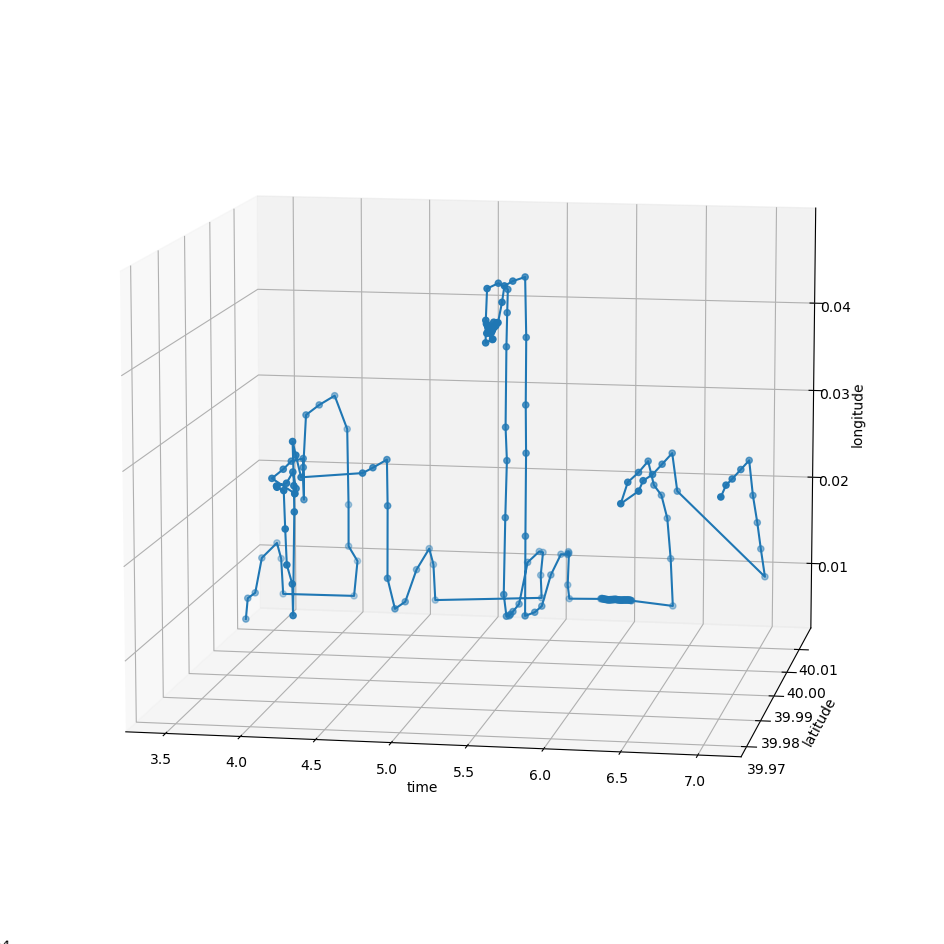

In [3]:
from convert_minmax_location import LocationPreprocessor
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as seaborn

import matplotlib.dates as dates
import datetime as dt

locationPreprocessor = LocationPreprocessor()
user_id = locationPreprocessor.getUserId(1)
csv_file = './Data/' + user_id + '/csv/' + user_id + '.csv'
csv_convert_file = './Data/' + user_id + '/csv/' + user_id + '_converted.csv'
user = pd.read_csv(csv_convert_file)

user_df = user[['latitude', 'longitude', 'x', 'y', 'days', 'time']].copy()

idx_list = []
for idx in range(user_df.shape[0]):
    if idx % 60 == 0: # 5 mins
        idx_list += [idx]
len(idx_list)

idx_list_partial = idx_list[-200:]
user_df_1 = user_df.iloc[idx_list_partial, :].copy()

plt.figure(figsize=(60, 12))
axes = plt.axes(projection='3d')
axes.view_init(elev=10, azim=-80)

# axes.scatter3D(user_df_1['days'], user_df_1['x'], user_df_1['y'], s=20)
# axes.plot3D(user_df_1['days'], user_df_1['x'], user_df_1['y'])
axes.scatter3D(user_df_1['days'], user_df_1['latitude'], user_df_1['longitude'], s=20)
axes.plot3D(user_df_1['days'], user_df_1['latitude'], user_df_1['longitude'])

axes.set_xlabel('time')
# axes.set_ylabel('X')
# axes.set_zlabel('Y')
axes.set_ylabel('latitude')
axes.set_zlabel('longitude')

user_df_1.head(5)

In [27]:
user_df
task_X = user_df.copy()
task_y = task_X.iloc[-5:, -2:].copy()

task_y.iloc[:, :]

,days,time
108602,0.0,0
108603,0.0,0
108604,0.0,0
108605,0.0,0
108606,0.0,0


In [10]:
# geopandas: https://datascientyst.com/plot-latitude-longitude-pandas-dataframe-python/
# pip install geopandas
# pip install Shapely

# folium: https://aboutnlp.tistory.com/33

import pandas as pd
from convert_minmax_location import LocationPreprocessor

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt

import folium
from branca.element import Figure

locationPreprocessor = LocationPreprocessor()

valid_user_list = locationPreprocessor.get_valid_user_list()

fig = Figure(width=550, height=350)
for id in valid_user_list['valid_user_list']:
    print(f"id: {id}")
    user_id = locationPreprocessor.getUserId(id)
    csv_file = './Data/' + user_id + '/csv/' + user_id + '.csv'
    csv_convert_file = './Data/' + user_id + '/csv/' + user_id + '_converted.csv'
    user = pd.read_csv(csv_file)
    user_location_list = user[['latitude', 'longitude']].values.tolist()
    center = user_location_list[0]
    
    map = folium.Map(location=center,
                     zoom_start=10)
    fig.add_child(map)
    folium.PolyLine(locations = user_location_list,).add_to(map)
    
    break

id: 0


In [31]:
# https://anweh.tistory.com/17

user_id = locationPreprocessor.getUserId(1)
csv_file = './Data/' + user_id + '/csv/' + user_id + '.csv'
csv_convert_file = './Data/' + user_id + '/csv/' + user_id + '_converted.csv'
user = pd.read_csv(csv_convert_file)
print(user.head())
user_coords = user[['latitude', 'longitude']].values.tolist()
lat = user['latitude'].mean()
lon = user['longitude'].mean()
center = [lat, lon]

map = folium.Map(location=center,
                    zoom_start=9)
k = 0
for i in range(len(user_coords)):
    if (i % 60) == 0:
        _color = '#' + str(k)
        k += 1
        folium.Circle(
            location = user_coords[i],
            radius = 20,
            # fill_color = 'Reds'
            # color = 'Reds', #'#000000',
            tooltip = user.iloc[i, -2:],
            fill = 'crimson',
        ).add_to(map)
map.save('map.html')

   Unnamed: 0      latitude      longitude  what  altitude          days  \
0           0 -67204.940037  914774.308307     0       492  39744.245197   
1           1 -67197.510538  914785.872580     0       492  39744.245208   
2           2 -67190.668971  914788.763648     0       492  39744.245266   
3           3 -67191.789356  914787.318114     0       492  39744.245324   
4           4 -67188.971857  914787.985283     0       491  39744.245382   

         date      time  
0  2008-10-23  05:53:05  
1  2008-10-23  05:53:06  
2  2008-10-23  05:53:11  
3  2008-10-23  05:53:16  
4  2008-10-23  05:53:21  


,latitude,longitude,x,y,days,time
105660,40.013796,116.306482,-68261.883641,918077.020018,39795.958229,22:59:51
105720,40.013801,116.306474,-68262.559944,918077.575993,39795.961701,23:04:51
105780,40.013824,116.306457,-68263.984711,918080.133476,39795.965174,23:09:51
105840,40.013810,116.306456,-68264.083877,918078.576747,39795.968646,23:14:51
105900,40.013810,116.306467,-68263.147084,918078.576747,39795.972118,23:19:51


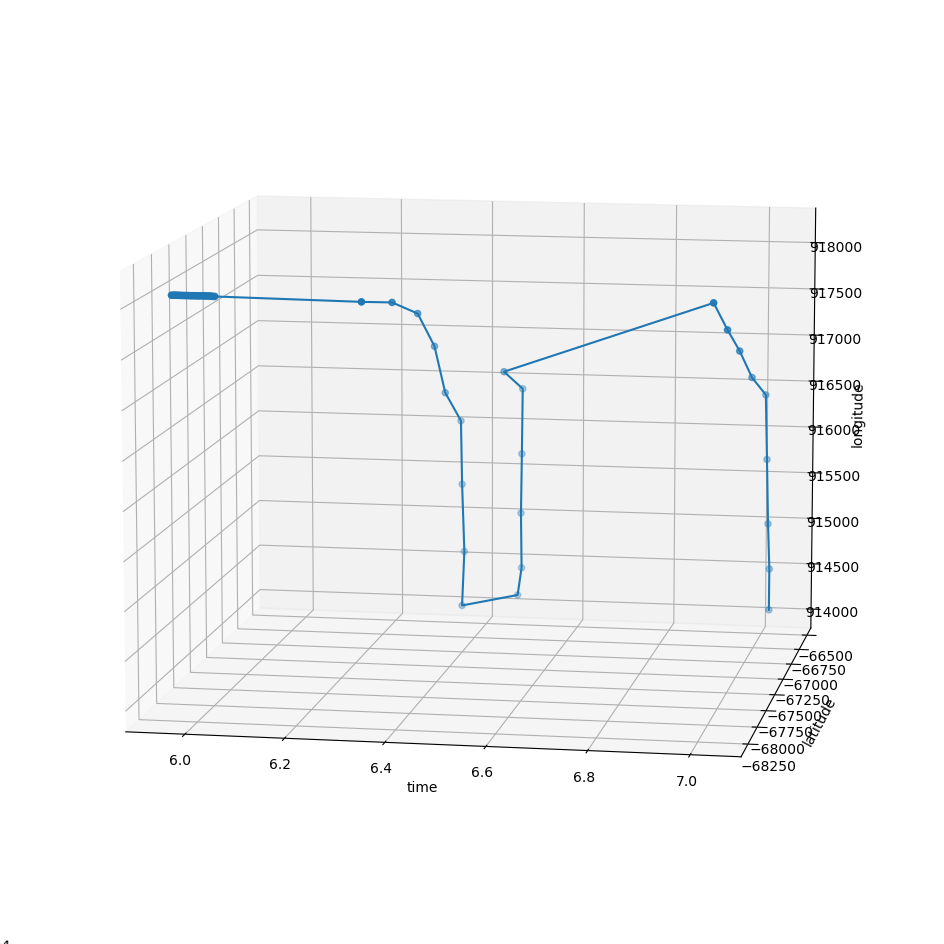

In [25]:
from convert_minmax_location import LocationPreprocessor
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as seaborn

import matplotlib.dates as dates
import datetime as dt

locationPreprocessor = LocationPreprocessor()
user_id = locationPreprocessor.getUserId(29)
csv_file = './Data/' + user_id + '/csv/' + user_id + '.csv'
csv_convert_file = './Data/' + user_id + '/csv/' + user_id + '_converted.csv'
user = pd.read_csv(csv_convert_file)
print(user.shape[0])
print(user.head(10))
# user = user.drop_duplicates(subset=['date', 'time'])
user = user.drop_duplicates(subset=['days'])
print(user.shape[0])

83844
    latitude   longitude  what  altitude          days        date      time  \
0  39.978320  116.332603     0       418  39826.237998  2009-01-13  05:42:43   
1  39.978299  116.332578     0       444  39826.238009  2009-01-13  05:42:44   
2  39.978244  116.332634     0       518  39826.238021  2009-01-13  05:42:45   
3  39.977434  116.332437     0       533  39826.238067  2009-01-13  05:42:49   
4  39.974798  116.332037     0       443  39826.238090  2009-01-13  05:42:51   
5  39.974574  116.332007     0       432  39826.238102  2009-01-13  05:42:52   
6  39.974450  116.331993     0       429  39826.238113  2009-01-13  05:42:53   
7  39.974512  116.331999     0       436  39826.238125  2009-01-13  05:42:54   
8  39.974329  116.331957     0       418  39826.238148  2009-01-13  05:42:56   
9  39.974242  116.331944     0       416  39826.238160  2009-01-13  05:42:57   

              x              y  
0 -66071.653469  914132.268801  
1 -66073.803957  914129.933707  
2 -66069.08552

In [47]:
user_df = user[['latitude', 'longitude', 'x', 'y', 'days', 'time']].copy()

idx_list = []
for idx in range(user_df.shape[0]):
    if idx % 120 == 0:
        idx_list += [idx]
len(idx_list)

idx_list_partial = idx_list[-50:]
user_df_1 = user_df.iloc[idx_list_partial, :].copy()
user_df_1.head()

,latitude,longitude,x,y,days,time
102720,39.996080,116.309192,-68048.747959,916107.090698,39795.566887,13:36:19
102840,40.004916,116.311273,-67862.695266,917089.609070,39795.570405,13:41:23
102960,40.014416,116.311401,-67842.350317,918145.960873,39795.573924,13:46:27
103080,40.014052,116.311816,-67807.369624,918105.485920,39795.585417,14:03:00
103200,40.013108,116.308182,-68117.793132,918000.517909,39795.592049,14:12:33


Text(0.5, 0, 'longitude')

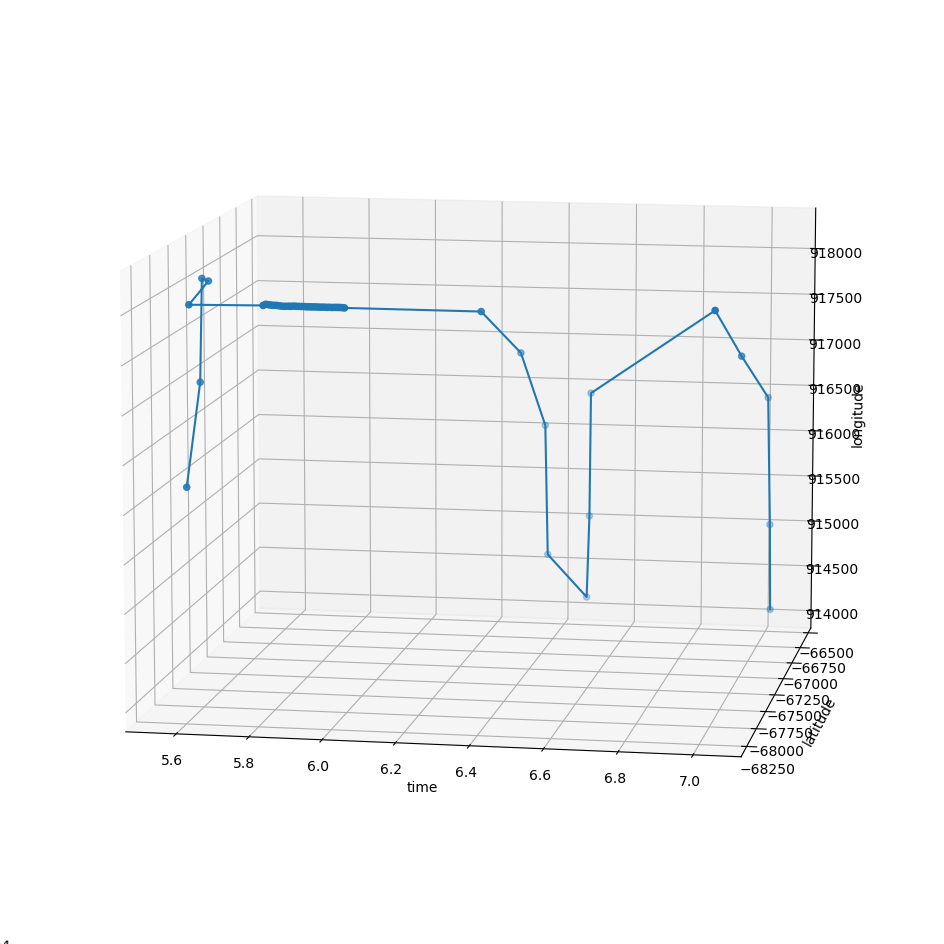

In [49]:
plt.figure(figsize=(60, 12))
axes = plt.axes(projection='3d')
axes.view_init(elev=10, azim=-80)

axes.scatter3D(user_df_1['days'], user_df_1['x'], user_df_1['y'], s=20)
axes.plot3D(user_df_1['days'], user_df_1['x'], user_df_1['y'])
axes.set_xlabel('time')
axes.set_ylabel('latitude')
axes.set_zlabel('longitude')

Text(0.5, 0, 'longitude')

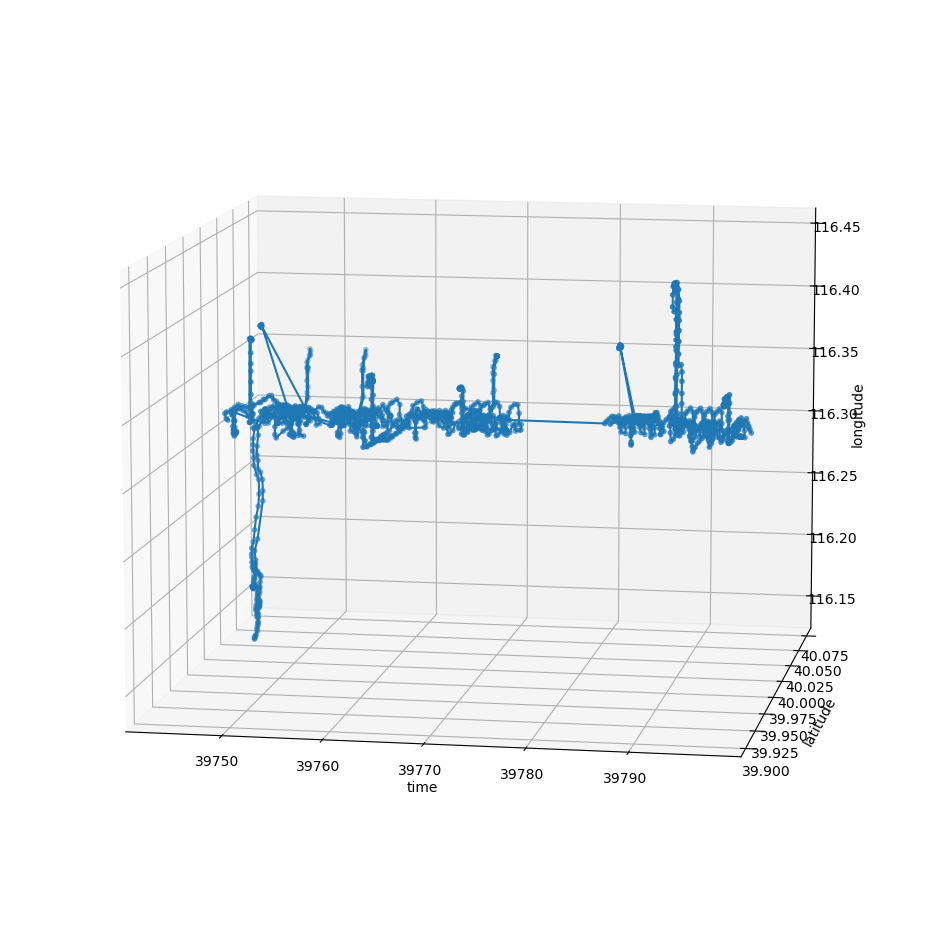

In [18]:
plt.figure(figsize=(60, 12))
axes = plt.axes(projection='3d')
axes.view_init(elev=10, azim=-80)

# axes.scatter3D(user_df_1['days'], user_df_1['x'], user_df_1['y'], s=10)
# axes.plot3D(user_df_1['days'], user_df_1['x'], user_df_1['y'])
axes.scatter3D(user_df_1['days'], user_df_1['latitude'], user_df_1['longitude'], s=10)
axes.plot3D(user_df_1['days'], user_df_1['latitude'], user_df_1['longitude'])
axes.set_xlabel('time')
axes.set_ylabel('latitude')
axes.set_zlabel('longitude')
# axes.set_xticklabels(one_hour['datetime'], rotation=45)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as seaborn

import matplotlib.dates as dates
import datetime as dt

user_id = locationPreprocessor.getUserId(1)
csv_file = './Data/' + user_id + '/csv/' + user_id + '.csv'
csv_convert_file = './Data/' + user_id + '/csv/' + user_id + '_converted.csv'
user = pd.read_csv(csv_convert_file)
print(user.head())
user_coords = user[['latitude', 'longitude']].values.tolist()

begin_hour = user_sub.iloc[0, -1]
end_hour = user_sub.iloc[-1, -1]

print('begin_hour:', begin_hour, ', end_hour:', end_hour)
count = 1
while begin_hour <= end_hour:
    condtion = (user_sub['hour'] >= begin_hour) & (user_sub['hour'] <= begin_hour + count)
    one_hour = user_sub.loc[condtion, :]
    begin_hour = begin_hour + count
    if one_hour.shape[0] < 1:
        continue

    plt.figure(figsize=(60, 12))
    axes = plt.axes(projection='3d')
    axes.view_init(elev=10, azim=-80)

    one_hour['time_reg'] = [str(dd.time()) for dd in one_hour['datetime']]
    axes.scatter3D(dates.date2num(one_hour['datetime']), one_hour['latitude'], one_hour['longitude'], s=10)
    axes.plot3D(dates.date2num(one_hour['datetime']), one_hour['latitude'], one_hour['longitude'])
    axes.set_xlabel('time')
    axes.set_ylabel('latitude')
    axes.set_zlabel('longitude')
    axes.set_xticklabels(one_hour['datetime'], rotation=45)

In [31]:
# location(Latitude, Logitude) 에 대한 최소, 최대값을 구해야 함.

import pandas as pd
import numpy as np

def getUserId(id):
    val = ""
    if id < 10:
        val += "00"
        val += str(id)
    elif id < 100:
        val += "0"
        val += str(id)
    else:
        val = str(id)
    return val

min_lat = 1000000 
min_lon = 1000000
max_lat = 0
max_lon = 0

min_lat_list = []
min_lon_list = []
max_lat_list = []
max_lon_list = []

user_id_list = []
for id in range(182):
    user_id = getUserId(id)
    csv_file = './Data/' + user_id + '/csv/' + user_id + '.csv'
    df = pd.read_csv(csv_file)
    if df.shape[0] < 500:
        continue

    user0 = df[['days', 'latitude', 'longitude']].copy()
    user_id_list += [user_id]
    min_lat_list += [user0['latitude'].min()]
    max_lat_list += [user0['latitude'].max()]
    min_lon_list += [user0['longitude'].min()]
    max_lon_list += [user0['longitude'].max()]
    
    # if user0['latitude'].min() < min_lat:
    #     min_lat = user0['latitude'].min()
    # if user0['latitude'].max() > max_lat:
    #     max_lat = user0['latitude'].max()
    # if user0['longitude'].min() < min_lon:
    #     min_lon = user0['longitude'].min()
    # if user0['longitude'].max() > max_lon:
    #     max_lon = user0['longitude'].max()

print(f"min_lat: {min_lat}, min_lon: {min_lon}")
print(f"max_lat: {max_lat}, max_lon: {max_lon}")

min_lat: 1000000, min_lon: 1000000
max_lat: 0, max_lon: 0


In [35]:
user_location_df = pd.DataFrame({'user_id':user_id_list,
                                'min_lat':min_lat_list,
                                'min_lon':min_lon_list,
                                'max_lat':max_lat_list,
                                'max_lon':max_lon_list})
user_location_df.head()

,user_id,min_lat,min_lon,max_lat,max_lon
0,000,31.095299,116.071547,40.210960,121.555706
1,001,39.900944,116.145054,40.076116,116.443578
2,002,37.230660,110.719933,40.052399,116.656566
3,003,31.095299,116.071547,40.223747,121.555706
4,004,31.167747,116.071590,41.367085,122.651456


In [70]:
user_location_df_pre = user_location_df.copy()
user_location_df_pre = user_location_df_pre.set_index('user_id', drop=True).copy()

X = ['min_lat', 'min_lon', 'max_lat', 'max_lon']
q1 = user_location_df_pre[X].quantile(0.25)
q3 = user_location_df_pre[X].quantile(0.75)
iqr = (q3-q1) * 1.5

cond1 = user_location_df_pre[X] >= (q1 - iqr)
# cond2 = user_location_df_pre[X] <= (q3 + iqr)

user_location_df_pre = user_location_df_pre[cond1].dropna().copy()
cond2 = user_location_df_pre[X] <= (q3 + iqr)
user_location_df_pre = user_location_df_pre[cond2].dropna()
valid_user_list = user_location_df_pre.index
print(f'valid user list: {valid_user_list}')


valid user list: Index(['000', '001', '003', '004', '005', '006', '007', '008', '009', '011',
       ...
       '165', '166', '169', '170', '173', '174', '177', '179', '180', '181'],
      dtype='object', name='user_id', length=126)


In [77]:
import os

df = pd.DataFrame({'valid_user_list':valid_user_list})
df.to_csv('valid_user_list.csv', index=False)

In [79]:
valid_user = pd.read_csv('valid_user_list.csv')
valid_user['valid_user_list']

# location(Latitude, Logitude) 에 대한 최소, 최대값을 구해야 함.

import pandas as pd
import numpy as np

def getUserId(id):
    val = ""
    if id < 10:
        val += "00"
        val += str(id)
    elif id < 100:
        val += "0"
        val += str(id)
    else:
        val = str(id)
    return val

min_lat = 1000000 
min_lon = 1000000
max_lat = 0
max_lon = 0

for id in valid_user['valid_user_list']:
    user_id = getUserId(id)
    csv_file = './Data/' + user_id + '/csv/' + user_id + '.csv'
    user0 = pd.read_csv(csv_file)
    
    if user0['latitude'].min() < min_lat:
        min_lat = user0['latitude'].min()
    if user0['latitude'].max() > max_lat:
        max_lat = user0['latitude'].max()
    if user0['longitude'].min() < min_lon:
        min_lon = user0['longitude'].min()
    if user0['longitude'].max() > max_lon:
        max_lon = user0['longitude'].max()

print(f"min_lat: {min_lat}, min_lon: {min_lon}")
print(f"max_lat: {max_lat}, max_lon: {max_lon}")

min_lat: 22.147577, min_lon: 111.564595
max_lat: 41.367085, max_lon: 122.651456


In [88]:
from valid_minmax_location import get_minmax_location

get_minmax_location()

min_lat: 22.147577, min_lon: 111.564595
max_lat: 41.367085, max_lon: 122.651456


([22.147577, 111.564595], [41.367085, 122.651456])

In [1]:
from valid_minmax_location import LocationPreprocessor

locationPreprocess = LocationPreprocessor()
center_locatuon = locationPreprocess.get_center_location()

earth_radius = 6371000

def convert_coord_for_blender(lat, lon):
    delta_lat = lat - center_locatuon[0]
    delta_lon = lon - center_locatuon[1]
    
    x = delta_lon * earth_radius * (np.pi / 180) * np.cos(lat * (np.pi / 180))
    y = delta_lat * earth_radius * (np.pi / 180)
 
    return x, y

In [ ]:
import numpy as np

def convert_coord_for_blender(self, lat, lon):
    delta_lat = lat - self.center_coord[0]
    delta_lon = lon - self.center_coord[1]

    x = delta_lon * self.earth_radius * (np.pi / 180) * np.cos(lat * (np.pi / 180))
    y = delta_lat * self.earth_radius * (np.pi / 180)
 
    return x, y
 
earth_radius = 6371000
lower_left_coord = [self.config['coords']['lower_left']['lat'], self.config['coords']['lower_left']['lon']]
upper_right_coord = [self.config['coords']['upper_right']['lat'], self.config['coords']['upper_right']['lon']]
center_coord = [
    (self.lower_left_coord[0] + self.upper_right_coord[0]) / 2,
    (self.lower_left_coord[1] + self.upper_right_coord[1]) / 2
]

In [3]:
import numpy as np

np.array(0).size

1

In [13]:
# Dataset 은 샘플과 정답(label)을 저장하고, 
# DataLoader 는 Dataset 을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감쌉니다.
# https://wikidocs.net/156998

import torch
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self):
    # 생성자, 데이터를 전처리하는 부분
        self.x_data = [[73, 80, 75],
                       [93, 99, 95]]
        self.y_data = [[152], 
                       [185]]
    
    def __len__(self):
    # 데이터셋의 총 길이를 반환하는 부분
        return len(self.x_data)
    
    def __getitem__(self, idx):
    # idx 에 해당하는 입출력 데이터를 반환한다.
        x = torch.FloatTensor(self.x_data[idx])
        y = torch.FloatTensor(self.y_data[idx])
        return x, y
    
customData = CustomDataset()
customData.__getitem__(1)

(tensor([93., 99., 95.]), tensor([185.]))

In [9]:
import os
import pandas as pd

index = 10
data_dir = 'Data/'
csv_dir = 'csv/'
csv_extension = '.csv'
user_path_list = os.listdir(data_dir)
csv_path = os.path.join(data_dir, user_path_list[index], csv_dir)
user_file = csv_path + user_path_list[index] + '.csv'
df = pd.read_csv(user_file)
df[["days","latitude", "longitude"]].head(20)



,days,latitude,longitude
0,39298.146204,39.921712,116.472343
1,39298.146215,39.921705,116.472343
2,39298.146227,39.921695,116.472345
3,39298.146238,39.921683,116.472342
4,39298.146250,39.921672,116.472342
5,39298.146273,39.921583,116.472315
6,39298.146285,39.921572,116.472315
7,39298.146296,39.921560,116.472290
8,39298.146308,39.921565,116.472290
9,39298.146319,39.921570,116.472288


In [130]:
import os
import pandas as pd
import numpy as np
import random
from torch.utils.data import Dataset

# Data folder 중 숫자가 안되는 User folder는 삭제하고
# 남은 User data에서 train-test 폴더로 나눈 후
# train_set(dataset), test_set(dataset) 으로 진행 필요

class GeoLifeDataSet(Dataset):
    def __init__(self, data_dir, user_list, samples_s, samples_q, length, y_timestep):
        self.data_dir   = data_dir
        self.csv_dir    = 'csv/'
        self.user_list  = user_list
        # user_list: all user
        self.samples_s  = samples_s
        # samples_s: the number of support set
        self.samples_q  = samples_q
        # samples_q: the number of query set
        self.length     = length 
        # length: the length of mini batch of a user
        self.y_timestep = y_timestep
        # y_time_step: the next time step to be predicted
        #              it must be less than length
    
    def sampleTime(self, dataset):
        cur_ds = dataset.copy()
        minibatch = []
        
        max_len = len(cur_ds)
        ###############################################
        # MAke sure samples from query and support 
        # do not intersect
        ##############################################
        # total_data_slice -> lenght 만큼 나눴을 때 총 slice 갯수
        total_data_slice = list(range(int(max_len/self.length)))
        total_samps = self.samples_q + self.samples_s
        
        slice_point = int(len(total_data_slice)*(self.samples_s/total_samps))
        # print(f"slice_point: {slice_point}")

        s_s_list = total_data_slice[:slice_point]
        q_s_list = total_data_slice[slice_point:]

        replace = False
        if total_samps > len(total_data_slice):
            replace = True

        s_s_list = np.random.choice(s_s_list, size=self.samples_s, replace=replace)
        q_s_list = np.random.choice(q_s_list, size=self.samples_q, replace=replace)
        
        # print(f"s_list:{s_s_list}")
        # print(f"q_list:{q_s_list}")
        choice_list = np.concatenate([s_s_list, q_s_list])
        # #################################################
        # print(f"choice_list: {choice_list}")
        
        for idx in choice_list:
            start_idx = idx * self.length
            if max_len - self.length >= 0:
                cur_sample = cur_ds.iloc[start_idx:(start_idx + self.length), :]
                minibatch.append(cur_sample)
            else:
                fill_quota  = np.abs(self.length - max_len)
                zeros_r     = np.zeros([fill_quota, cur_ds.shape[1]])
                cur_sample  = cur_ds[:, :]
                cur_sample  = np.concatenate([zeros_r, cur_sample], axis = 0)
                minibatch.append(cur_sample)
        return np.array(minibatch)
        
    def __getitem__(self, index):
        csv_path = os.path.join(self.data_dir, self.user_list[index], self.csv_dir)
        user_file = csv_path + self.user_list[index] + '.csv'
        df = pd.read_csv(user_file)
        df = df[['days','latitude', 'longitude']]

        samples = self.sampleTime(df)
        # print(f"mini_batch: {samples.shape}")
        # mini_batch: (5, 10, 3)
        
        sup_x = np.array(samples[:self.samples_s, :-self.y_timestep, :])
        sup_y = np.array(samples[:self.samples_s, -self.y_timestep:, -2:])
        que_x = np.array(samples[self.samples_s:, :-self.y_timestep, :])
        que_y = np.array(samples[self.samples_s:, -self.y_timestep:, -2:])

        return (que_x, sup_x, sup_y), que_y
    
    def __len__(self):
        # batch를 구성할 수 있는 총 수
        # 이 수에서 batch를 조정할 수 있다.
        # 몇 명의 user 로 나눠서 할 지
        return len(self.user_list)

user_list = os.listdir(data_dir)
random.shuffle(user_list)
train_size = 0.1
train_list = user_list[:(int)(len(user_list)*train_size)]
print(f"train_list: {len(train_list)}")

# dataset = GeoLifeDataSet("Data/", [0, 1, 2, 3], 5, 2, 100, 10)
# dataset.__getitem__(0)

train_list: 18


In [145]:
from torch.utils.data import DataLoader

data_dir = "Data/"#"data/geolife/Data/"
sample_s = 5
sample_q = 3
length = 100
y_timestep = 10

user_list = os.listdir(data_dir)
random.shuffle(user_list)
train_size = 0.1
train_list = user_list[:(int)(len(user_list)*train_size)]
test_list  = user_list[(int)(len(user_list)*train_size):]
print(f"train_list: {len(train_list)}")

training_data = GeoLifeDataSet(data_dir, train_list, sample_s, sample_q, length, y_timestep)
test_data = GeoLifeDataSet(data_dir, train_list, sample_s, sample_q, length, y_timestep)

train_dataloader = DataLoader(training_data, batch_size=1, shuffle=False)
test_dataloader  = DataLoader(test_data, batch_size=1, shuffle=False)

train_x, train_y = next(iter(train_dataloader))
print(f"support_x: {train_x[0].shape}")
print(f"support_y: {train_x[1].shape}")
print(f"query_x: {train_x[2].shape}")
print(f"query_y: {train_y.shape}")

train_list: 18
support_x: torch.Size([1, 3, 90, 3])
support_y: torch.Size([1, 5, 90, 3])
query_x: torch.Size([1, 5, 10, 2])
query_y: torch.Size([1, 3, 10, 2])


NameError: name 'shap' is not defined

In [4]:
shape = [1, 2, 3, 4, 5]
shape[:-2] + [-1] + [2]

[1, 2, 3, -1, 2]

In [ ]:
        # input is TASKS x SAMPLES x FEATURES x TIME x Latent vector
        shape = torch._shape_as_tensor(inp)
        # (3, 20, 6, 100, 1)
        x = torch.reshape(inp, [-1, shape[-2], shape[-1]])
        # (300, 100, 1)
        x, f = self.gru(x)
        # x:(300, 100, 32)
        # f:(3, 100, 32)
        
        if self.final:
            new_shape = shape[:-2].tolist() + [-1]
            out = torch.reshape(f, new_shape)
        else:
            new_shape = shape[:-1].tolist() + [-1]
            # (3, 20, 6, 100, -1)
            out = torch.reshape(x, new_shape)
            # (3, 20, 6, 100, 32)
        return out

In [ ]:
# DataLoader
from torch.utils.data import DataLoader

dataloader = DataLoader(
    dataset,
    batch_size = 2,
    shuffle = True,
)

In [6]:
import pandas as pd
import numpy as np
import torch

from sklearn.cluster import KMeans

df = pd.read_csv('Data/000/csv/000.csv')
df.head(1)

,latitude,longitude,what,altitude,days,date,time
0,39.984702,116.318417,0,492,39744.120185,2008-10-23,02:53:04


In [4]:
import pandas as pd
import numpy as np
import torch

from sklearn.cluster import KMeans

df = pd.read_csv('Data/001/csv/001.csv')
df.head(5)

,latitude,longitude,what,altitude,days,date,time
0,39.984094,116.319236,0,492,39744.245197,2008-10-23,05:53:05
1,39.984198,116.319322,0,492,39744.245208,2008-10-23,05:53:06
2,39.984224,116.319402,0,492,39744.245266,2008-10-23,05:53:11
3,39.984211,116.319389,0,492,39744.245324,2008-10-23,05:53:16
4,39.984217,116.319422,0,491,39744.245382,2008-10-23,05:53:21


In [1]:
import pandas as pd
import numpy as np
import torch

from sklearn.cluster import KMeans

df = pd.read_csv('Data/000/csv/000.csv')
df.head(1)
df_temp = df[['latitude', 'longitude']].copy()

model = KMeans(n_clusters=100, random_state=123)
model.fit(df_temp)


/home/shkoma/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=100, random_state=123)

In [14]:
df_temp['label'] = model.labels_
df_temp['label'].value_counts()

31    23021
12    22060
72    14927
58    14561
66    11336
      ...  
99      111
29      101
43       94
91       92
96       78
Name: label, Length: 100, dtype: int64